# statsmodels API

This notebook demonstrates how to use the statsmodels library for time series analysis and forecasting on real-time Bitcoin price data. The raw price data is ingested using the CoinGecko API, and all data preprocessing, modeling, and forecasting are performed using the statsmodels API.

The Python wrapper layer built around statsmodels includes:
- Preparing time-indexed Bitcoin price data.
- Applying ARIMA models to forecast future price trends.
- Handling model fitting, prediction, and visualization in reusable functions.

All utility functions used in this notebook are defined in statsmodels_utils.py. These functions provide a modular and maintainable interface over the base statsmodels API. For design decisions and function-level documentation, refer to statsmodels.API.md.

This notebook is intended to demonstrate the functionality of the statsmodels library via our software abstraction. For a full end-to-end application, see statsmodels.example.ipynb.

References:
- statsmodels Documentation: https://www.statsmodels.org/
- statsmodels.API.md
- CoinGecko API Documentation: https://www.coingecko.com/en/api/documentation
- Jupyter Notebook Style Guide: https://github.com/causify-ai/helpers/blob/master/docs/coding/all.jupyter_notebook.how_to_guide.md

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [14]:
import logging
import Statsmodels_utils as smu  
import warnings
warnings.filterwarnings("ignore")

# Set up basic logging configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

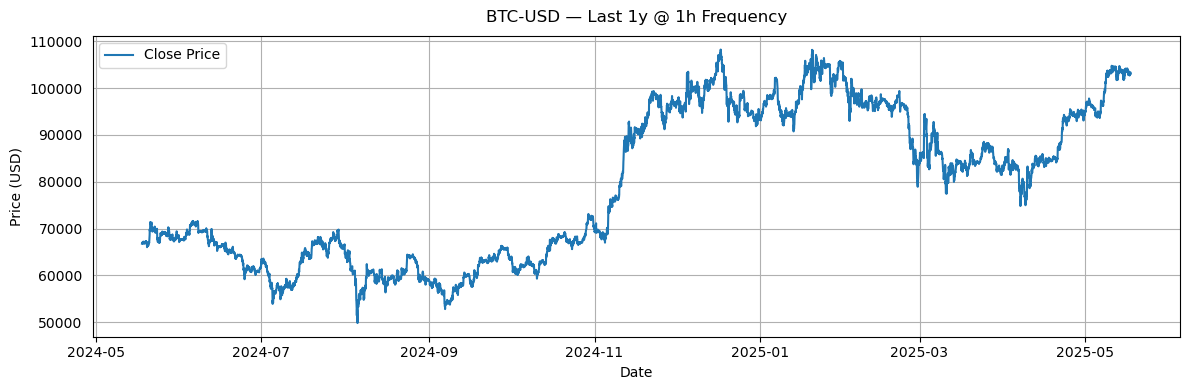

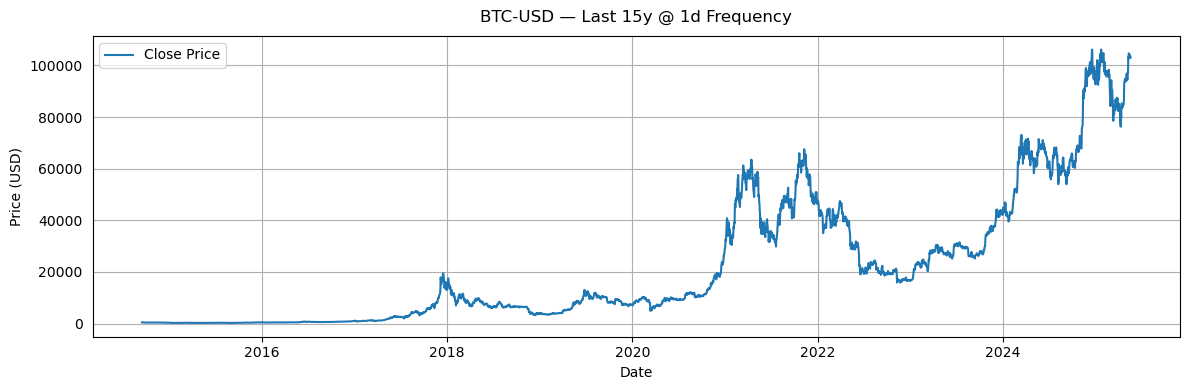

In [164]:
# 2. Import your utils module (adjust case to match your filename)
import Statsmodels_utils as smu

# Hourly (1 year)
btc_hourly = smu.fetch_and_plot_btc_hourly()

# Daily (15 years)
btc_daily  = smu.fetch_and_plot_btc_daily()


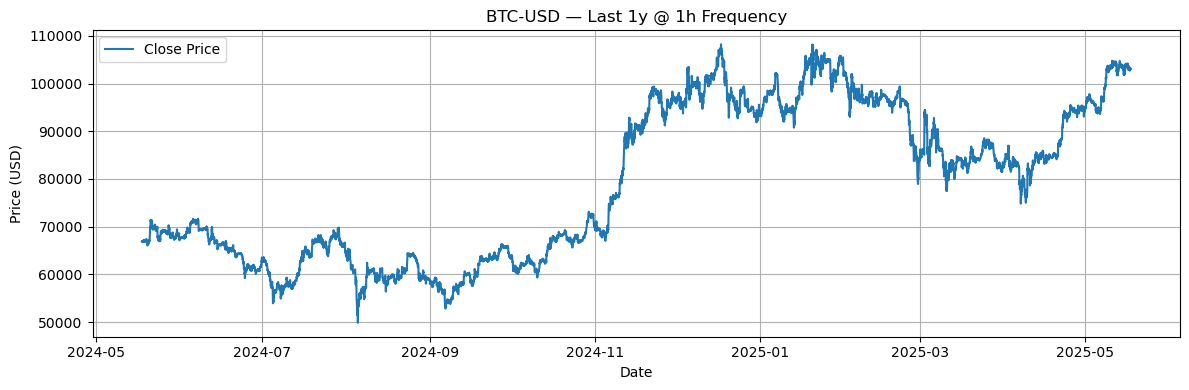

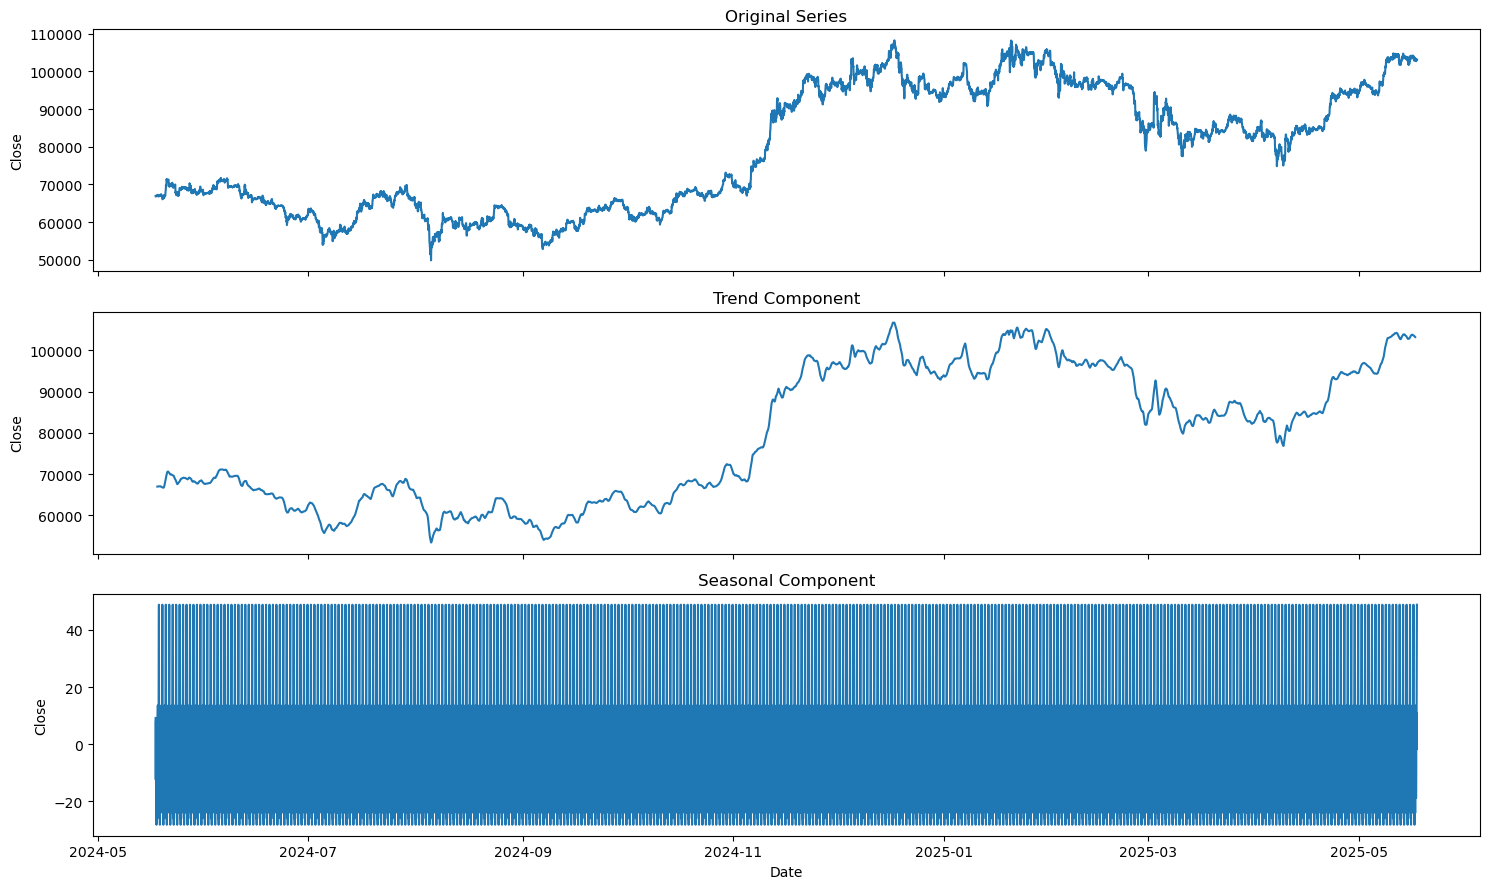

In [23]:
btc_hourly = smu.fetch_and_plot_btc_hourly()
smu.plot_trend_and_seasonality(df=btc_hourly, column="Close", period=24)


In [78]:
# Convert your differenced Series to a DataFrame (if not already)
btc_diff_df = btc_diff.to_frame(name="Close_diff")

# Save to CSV with pandas
btc_diff_df.to_csv("btc_hourly_diff.csv", index=True)


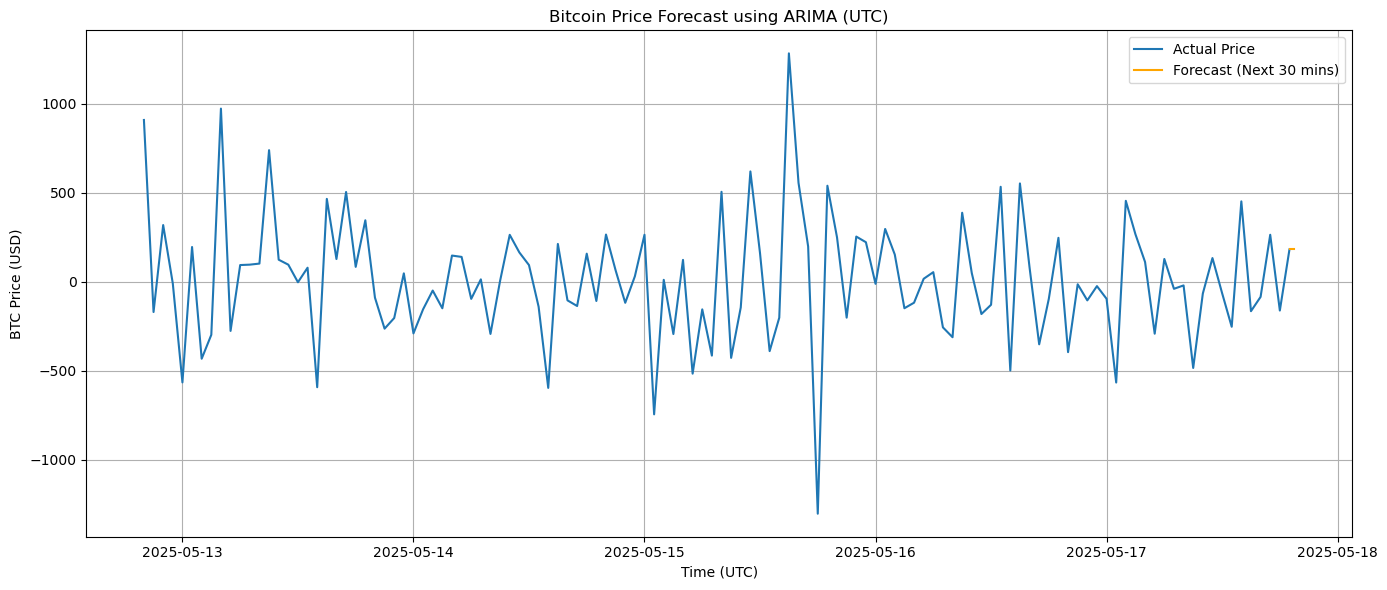

In [98]:
# 1) Convert the differenced series to a DataFrame named “price”
btc_diff_df = btc_diff.to_frame(name="price")

# 2) Fit ARIMA (order is inferred from your run_arima_analysis defaults)
model_res, forecast = smu.run_arima_analysis(btc_diff_df)

# 3) Plot the forecast
smu.plot_forecast(btc_diff_df, forecast)

- I first convert my stationary, differenced series (`btc_diff`) into a DataFrame called “price.” By passing this already‐detrended data to `run_arima_analysis`, I’m explicitly modeling the *changes* in Bitcoin’s price over time. The ARIMA forecast then predicts how much the price will move in the next 30 minutes, and `plot_forecast` visualizes those expected *increments* on top of the stationary differenced series.


- **Running ARIMA Without Manual Detrending**  
Here I’m using the full 1-year hourly series (renamed to “price”) and feeding it directly into `run_arima_analysis`—no prior differencing step on my part. The function still resamples to 1-minute frequency and uses the ARIMA(2,1,2) model’s built-in differencing, but I’m not manually detrending first. By comparing these results and the resulting plots to those from the manually differenced series, you can clearly observe how explicit detrending affects forecast behavior and accuracy.
``


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


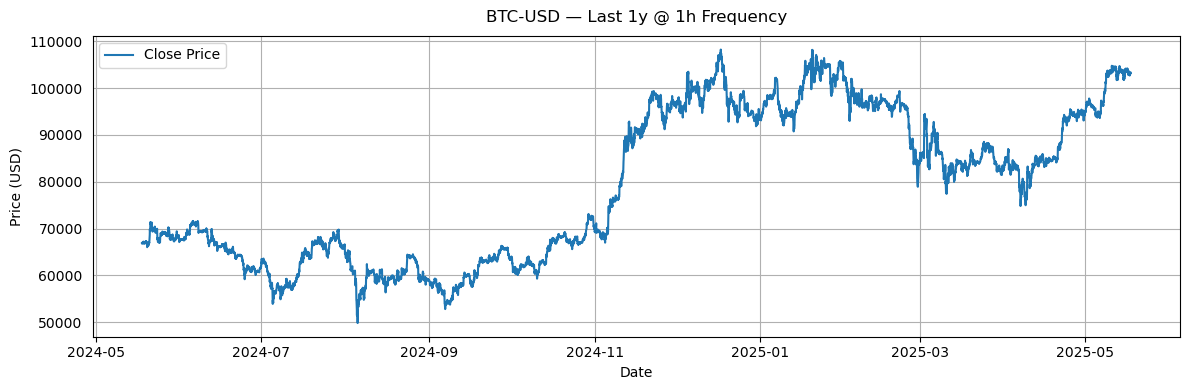

                               SARIMAX Results                                
Dep. Variable:                BTC-USD   No. Observations:                 8760
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -65744.945
Date:                Sat, 17 May 2025   AIC                         131491.889
Time:                        17:38:51   BIC                         131498.967
Sample:                             0   HQIC                        131494.301
                               - 8760                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.937e+05   1134.723    170.688      0.000    1.91e+05    1.96e+05
Ljung-Box (L1) (Q):                   2.52   Jarque-Bera (JB):             46702.51
Prob(Q):                              0.11   Pr

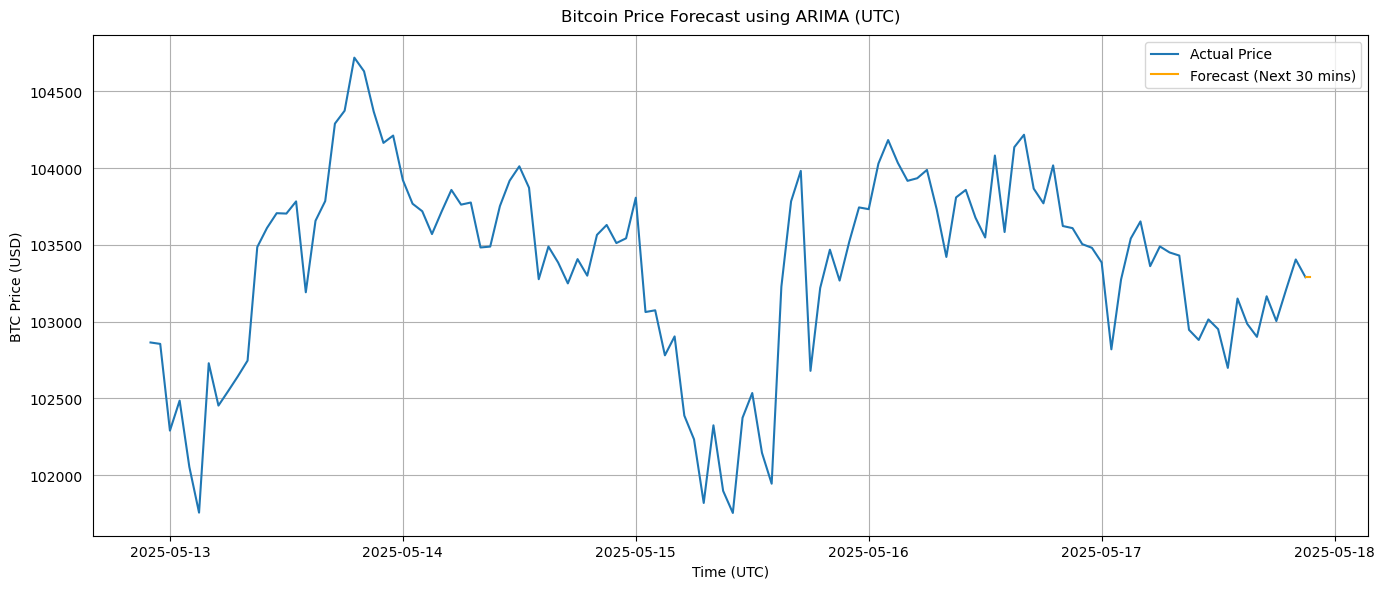

In [110]:
# 1) Reload utils
%load_ext autoreload
%autoreload 2

import Statsmodels_utils as smu
from statsmodels.tsa.arima.model import ARIMA

# 2) Prepare the price series
btc_hourly = smu.fetch_and_plot_btc_hourly()
df_price   = btc_hourly[['Close']].rename(columns={'Close':'price'})

# 3) ARIMA(0,1,0)
model_simple = ARIMA(df_price['price'], order=(0,1,0))
res_simple   = model_simple.fit()
print(res_simple.summary())

# 4) Forecast next 30 steps (minutes by default in your util) and plot
forecast_simple = res_simple.forecast(steps=30)
smu.plot_forecast(df_price, forecast_simple)


<Figure size 1000x400 with 0 Axes>

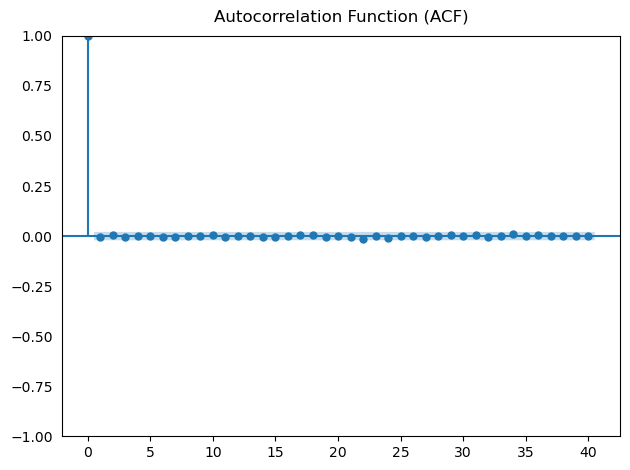

<Figure size 1000x400 with 0 Axes>

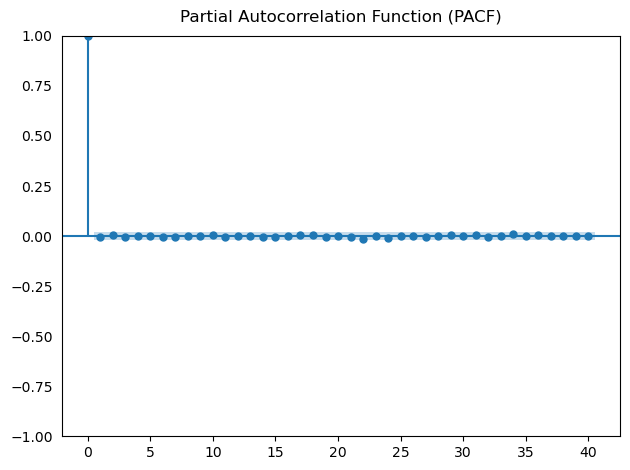

In [114]:
# 1) Extract residuals and rename to “price”
resid = res_simple.resid
resid_df = resid.to_frame(name="residual").rename(columns={'residual': 'price'})

# 2) Plot ACF & PACF of the residuals as if they were the “price” series
smu.plot_acf_pacf(resid_df, lags=40)


- Now that residual ACF and PACF show no significant lags, the next step is to formally test for white‐noise residuals  and, if they pass, you can have confidence that your ARIMA(0,1,0) model has captured all the serial dependence. Here’s how to proceed:

In [116]:
# 1) Perform the Ljung–Box test at several lags
from statsmodels.stats.diagnostic import acorr_ljungbox

# Use the residual series you already have
resid = res_simple.resid.dropna()

# Test at lags 10, 20, and 30
lb_results = acorr_ljungbox(resid, lags=[10,20,30], return_df=True)
print(lb_results)


     lb_stat  lb_pvalue
10  0.861322   0.999914
20  1.989386   1.000000
30  4.840293   1.000000


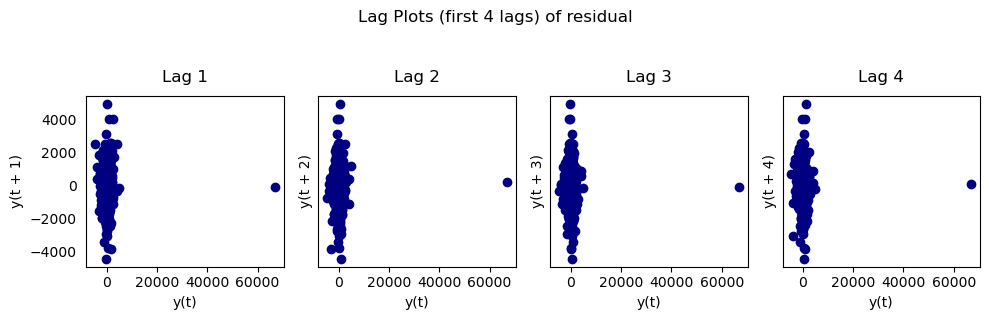

In [118]:
# 1) Extract and rename residuals for plotting
resid = res_simple.resid.dropna()
resid_df = resid.to_frame(name="residual")

# 2) Plot lag plots for the first 4 lags
smu.plot_lag_series(resid_df, column="residual", lags=4, figsize=(10,3), dpi=100, color="navy")


The residual lag‐plots reinforce the Ljung–Box findings:

* **Most points cluster tightly around the origin** with no obvious diagonal pattern, indicating little to no serial dependence in successive residuals.
* **A few extreme outliers** (points far off at high values) reflect rare large shocks, but they aren’t part of a systematic autocorrelation pattern.
* Overall, the cloud‐like scatter—with no elongated shape—confirms that the residuals behave like white noise.

Together with the Ljung–Box p-values, this gives us confidence that our simple ARIMA(0,1,0) model has captured all meaningful structure in the data and that the remaining residuals are essentially random.


# Time series analysis of Bitcoin using statsmodels on daily data


## Load and simulate 1-day + 3-minute real-time BTC data

## Step 1: Load 1-Day BTC Price Data

In [16]:
btc_df = smu.fetch_historical_data()
btc_df.head()

,price
timestamp,
2025-05-16 23:30:00+00:00,103676.772739
2025-05-16 23:35:00+00:00,103657.737930
2025-05-16 23:41:00+00:00,103646.886404
2025-05-16 23:46:00+00:00,103621.480980
2025-05-16 23:51:00+00:00,103596.907521


## Step 2: Simulate Real-Time Streaming (3 Minutes)

In [18]:
btc_df = smu.fetch_historical_data()
btc_df = smu.simulate_realtime(btc_df, minutes=3)

INFO:Statsmodels_utils:Simulating 3 minutes of real-time price updates...
INFO:Statsmodels_utils:[2025-05-17 23:29:54.596019+00:00] Appended price: $103139
INFO:Statsmodels_utils:[2025-05-17 23:30:54.675358+00:00] Appended price: $103141
INFO:Statsmodels_utils:[2025-05-17 23:31:54.776781+00:00] Appended price: $103145


## Step 3: Visualize Raw BTC Price Time Series


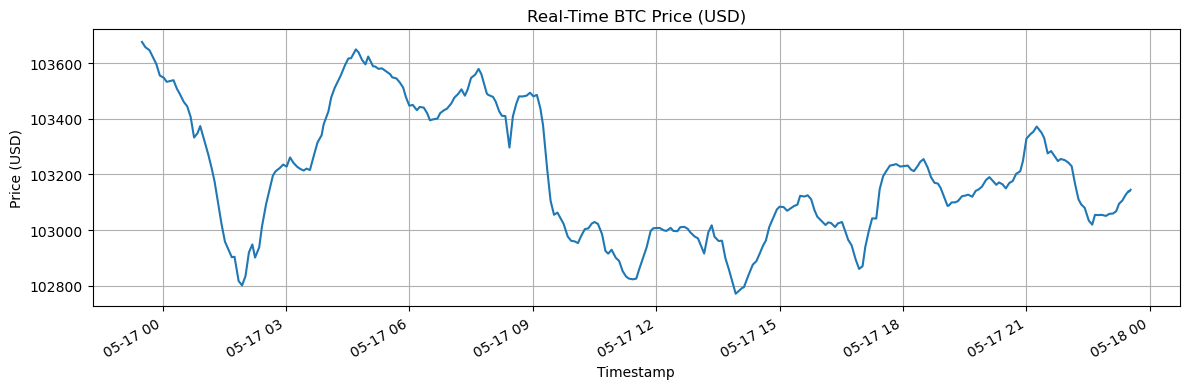

In [23]:
smu.plot_time_series(btc_df)

## Step 4: Plot ACF and PACF

<Figure size 1000x400 with 0 Axes>

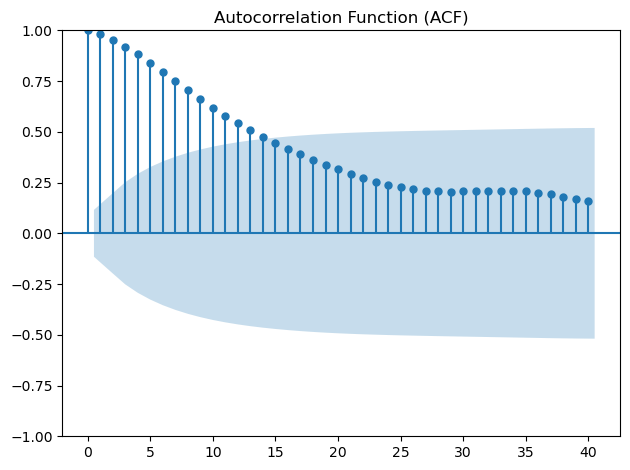

<Figure size 1000x400 with 0 Axes>

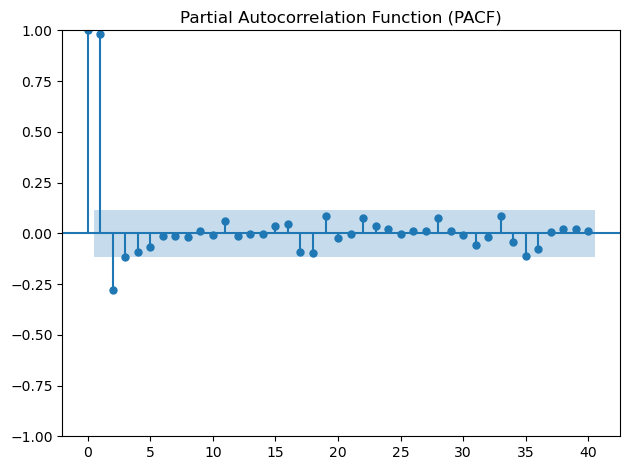

In [24]:
smu.plot_acf_pacf(btc_df)

## Step 5: Fit ARIMA Model and Forecast 30 Steps

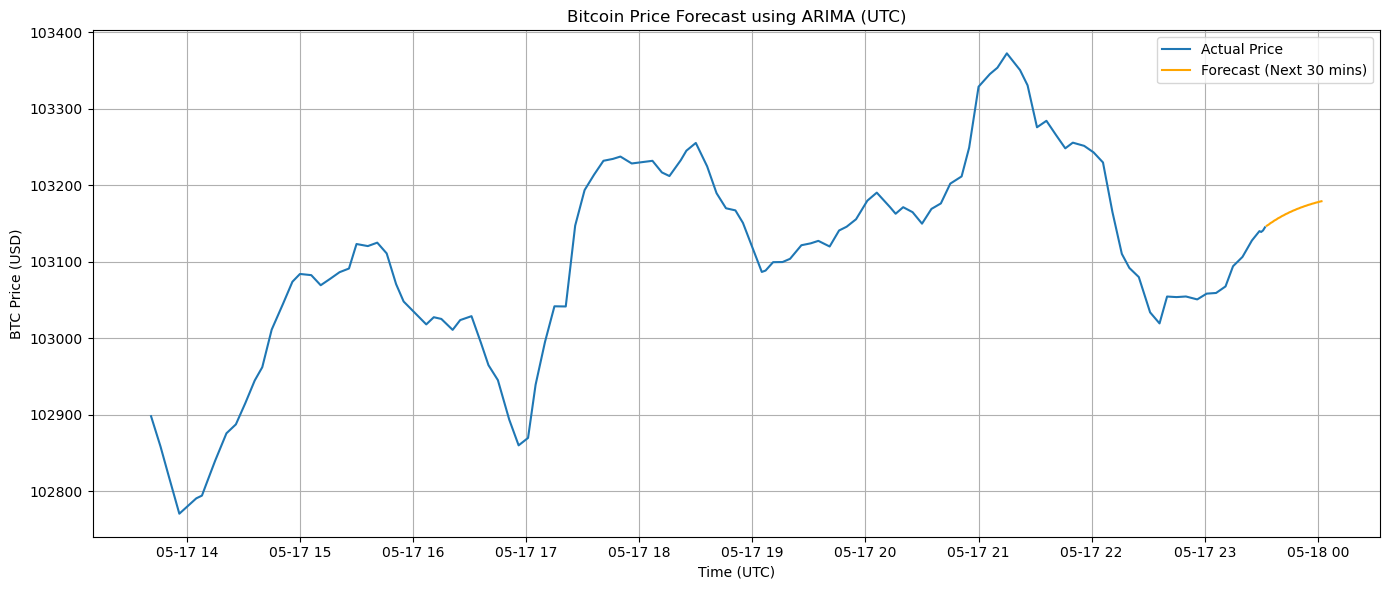

In [25]:
model_results, forecast = smu.run_arima_analysis(btc_df)
smu.plot_forecast(btc_df, forecast)

## Save Results to CSV

## Compare Historical BTC Prices at Different Time Scales

INFO:Statsmodels_utils:Saved data for Last 1 Day to btc_1day.csv


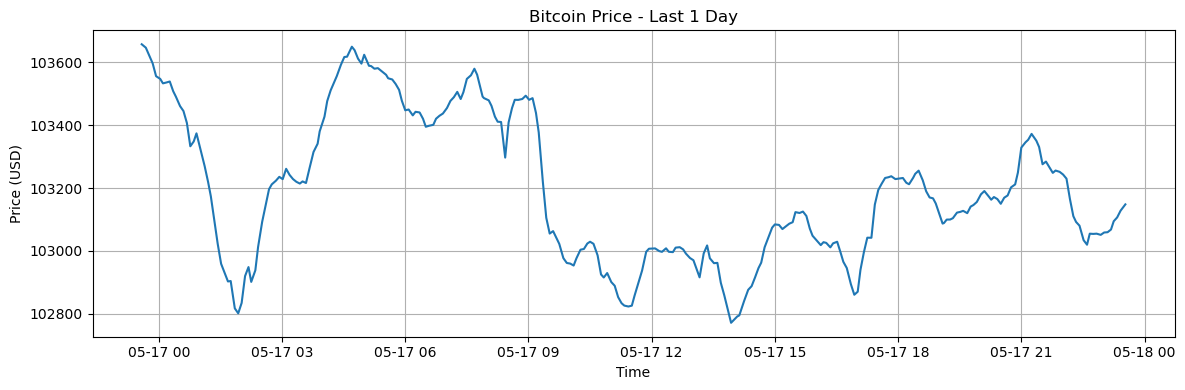

INFO:Statsmodels_utils:Saved data for Last 30 Days to btc_30days.csv


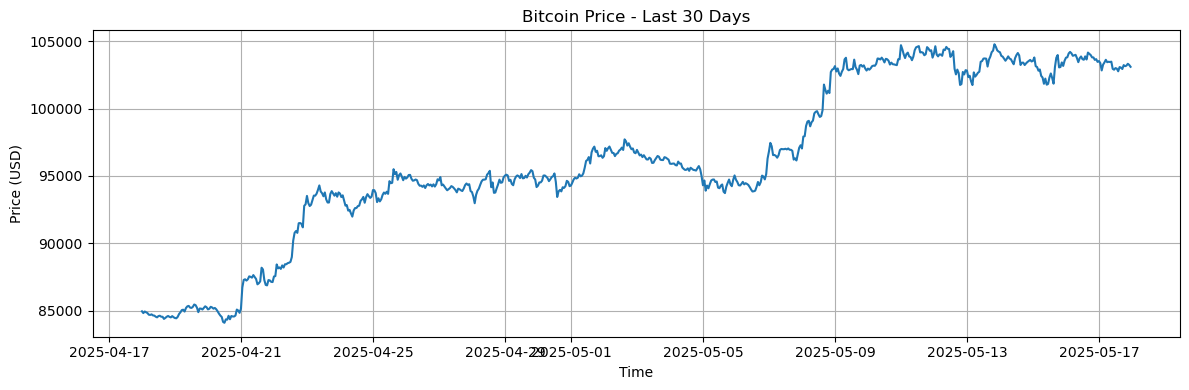

INFO:Statsmodels_utils:Saved data for Last 1 Year to btc_1year.csv


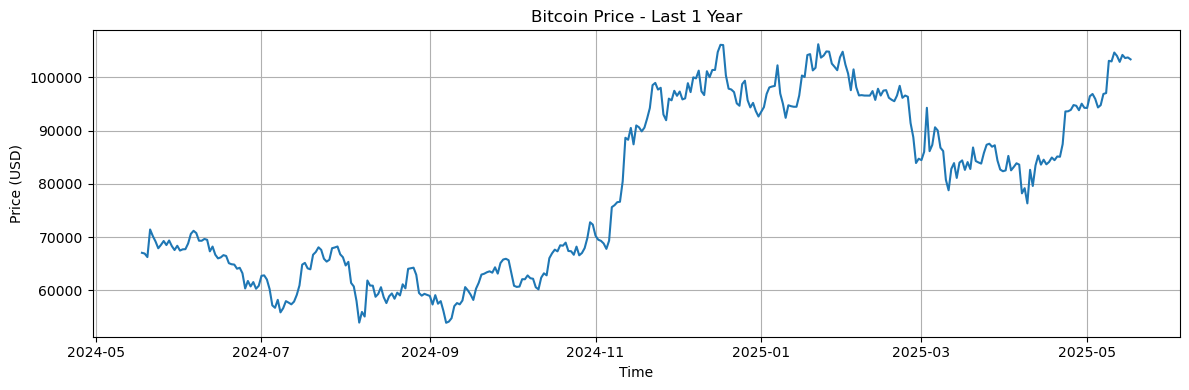

In [26]:
btc_1d = smu.fetch_and_process_data(1, "btc_1day.csv", "Last 1 Day")
btc_30d = smu.fetch_and_process_data(30, "btc_30days.csv", "Last 30 Days")
btc_1y = smu.fetch_and_process_data(365, "btc_1year.csv", "Last 1 Year")